## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal,io
from scipy.ndimage import median_filter as medfilt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.utils.extmath import randomized_svd as rsvd

from utils import tic, toc, hankel_matrix, scaler, legendre_polys, find_opt_lag, generate_color_gradient
from models import linear_regression, VAE

%matplotlib inline

2025-01-07 17:30:52.315224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 17:30:52.485151: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 17:30:53.014824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-01-07 17:30:53.014877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Load and preprocess data

In [2]:
def load_pupil(subj,filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_pupil.mat')
    pupil = data_dict['pupil'].reshape(-1,1)
    pupil = medfilt(pupil,21)
    
    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        pupil = signal.sosfiltfilt(sos, pupil, axis=0)
    
    pupil = pupil[1000:-800,:]
    
    pupil = StandardScaler(with_std=False).fit_transform(pupil)

    return pupil

In [3]:
def load_brain(subj,modality='jrgeco',filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_' + modality + '.mat')
    brain = data_dict['data'][:,mask_long]

    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        brain = signal.sosfiltfilt(sos, brain, axis=0)
        
    brain = brain[1000:-800,:]
    
    brain = StandardScaler(with_std=False).fit_transform(brain)

    return brain

In [4]:
data_dir = '/home/ryanr/widefield'
outdir = '/home/ryanr/Allen/arousal_final/model_predictions_indv'
figdir = '/home/ryanr/Allen/arousal_final/figs'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [5]:
from numpy.random import seed
seed(1)
keras.utils.set_random_seed(1)

## Analysis

In [6]:
## Set modeling parameters

subjects = [4,5,6,7,8,9,10]
delay = 1 # implement delay embedding? 0 or 1
nonlinear = 1 # use nonlinear mappings (VAE) (as opposed to linear regression) ? 0 or 1
Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 4 # number of latent dimensions used for VAE
num_epochs = 200 # number of training epochs
lr = .01 # learning rate
beta = 1 # beta weight for KL loss in VAE training
anneal_step = 200 # determines rate at which KL loss is increased during training
pretrained_enc = [] # pretrained encoder

In [7]:
modality = 'jrgeco'
nsamples = 6000

for s in range(len(subjects)):
    
    tic()
    
    print(str(s))
    
    subj = subjects[s]

    # Load data
    x = load_pupil(subj)
    y = load_brain(subj)
    
    for m in range(4):
        if m==0:
            delay = 1
            nonlinear = 1
        elif m==1:
            delay = 1
            nonlinear = 0
        elif m==2:
            delay = 0
            nonlinear = 1
        else:
            delay = 0
            nonlinear = 0
    
        ## Train-test split
        xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=x.shape[0]-nsamples,shuffle=False)
        xtest = xtest[1000:,:] # enforce 50s (50/dt) gap to mitigate overlap between train and test
        ytest = ytest[1000:,:]

        ## Adjust for pupil:brain lag

        # Find lag
        lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
        lag_range = int(lag_range/dt)
        lag,_,_ = find_opt_lag(xtrain,np.mean(ytrain,axis=1),lag_range)

        # Adjust
        if lag:
            xtrain = xtrain[lag:,:]
            ytrain = ytrain[:-lag,:]

            xtest = xtest[lag:,:]
            ytest = ytest[:-lag,:]

        # Time delay embedding    
        polys = legendre_polys(r, stackmax)

        Hp_train = hankel_matrix(xtrain.T,stackmax,spacing)
        Hp_test = hankel_matrix(xtest.T,stackmax,spacing)

        xtrain = Hp_train.T@polys
        xtest = Hp_test.T@polys

        xtrain = np.concatenate((xtrain,Hp_train.T[:,-1:]), axis=1)
        xtest = np.concatenate((xtest,Hp_test.T[:,-1:]), axis=1)
        
        ytrain = ytrain[spacing*(stackmax-1):,:]
        ytest = ytest[spacing*(stackmax-1):,:]

        if not delay:
            xtrain = xtrain[:,-1:]
            xtest = xtest[:,-1:]

        # Preprocessing    
        xtrain_sc, scale_x = scaler(xtrain)
        ytrain_sc, scale_y = scaler(ytrain)

        ## Train model
        if nonlinear:
            r_squared, model, encoder, decoder = VAE(xtrain_sc, ytrain_sc, latent_dim=z_n, beta=beta,
                                                     num_epochs=num_epochs, anneal_step=anneal_step, verbose=False)
        else:
            r_squared, model = linear_regression(xtrain_sc, ytrain_sc)

        #ytrain_hat_sc = model.predict(xtrain_sc)
        #ytrain_hat = scale_y.inverse_transform(ytrain_hat_sc)

        # Test model
        xtest_sc,_ = scaler(xtest, scale_x)

        ytest_hat_sc = model.predict(xtest_sc)
        ytest_hat = scale_y.inverse_transform(ytest_hat_sc)

        # Save files
        if delay & nonlinear:
            np.save(outdir + '/' + str(subj) + '_' + modality + '_delay_xtest.npy', xtest)
            np.save(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy', ytest)
            np.save(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy', ytest_hat)

            encoder.save_weights(outdir + '/' + str(subj) + '_' + modality + '_encoder_weights.h5')
            decoder.save_weights(outdir + '/' + str(subj) + '_' + modality + '_decoder_weights.h5')

        elif delay:
            np.save(outdir + '/' + str(subj) + '_' + modality + '_delay_lin_ytest_hat.npy', ytest_hat)

        elif nonlinear:
            np.save(outdir + '/' + str(subj) + '_' + modality + '_nodelay_nonlin_ytest_hat.npy', ytest_hat)

        else:
            np.save(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy', ytest_hat)
            
    toc()

0


2025-01-07 17:31:03.137454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 17:31:05.112056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9627 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2025-01-07 17:31:05.112838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9627 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2025-01-07 17:31:05.113465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/repli

Elapsed time is 58.142900466918945 seconds.
1
Elapsed time is 55.52259826660156 seconds.
2
Elapsed time is 54.48200988769531 seconds.
3
Elapsed time is 53.43138360977173 seconds.
4
Elapsed time is 53.93231725692749 seconds.
5
Elapsed time is 54.35589551925659 seconds.
6
Elapsed time is 54.99040198326111 seconds.


## $R^2$ plots

In [8]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [9]:
scores = np.zeros([len(subjects),4])

for s in range(len(subjects)):
    
    subj = subjects[s]
    
    ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')
    
    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
    scores[s,0] = r2_score(ytest, ytest_hat, multioutput = 'variance_weighted')
    
    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_nonlin_ytest_hat.npy')
    scores[s,1] = r2_score(ytest, ytest_hat, multioutput = 'variance_weighted')
    
    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_lin_ytest_hat.npy')
    scores[s,2] = r2_score(ytest, ytest_hat, multioutput = 'variance_weighted')
    
    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')
    scores[s,3] = r2_score(ytest, ytest_hat, multioutput = 'variance_weighted')

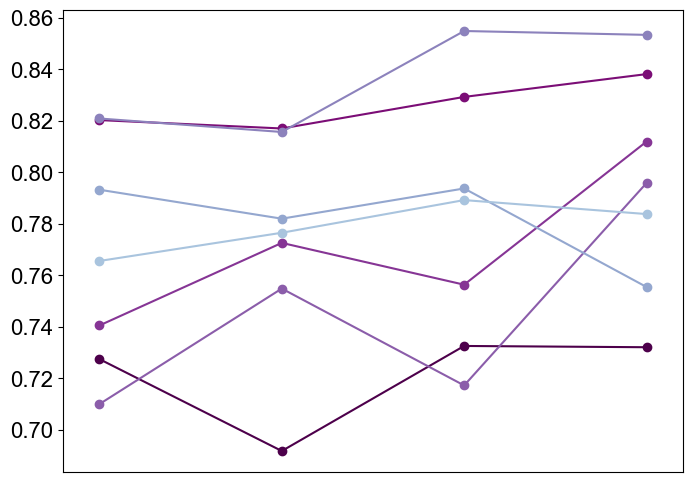

In [10]:
line_colors = generate_color_gradient(len(subjects)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subjects)):
    plt.plot(scores[i,:].T,  markersize=12, marker = '.', color=line_colors[i])
    
ax.set_xticks([])
ax.set_xlim([-.2,3.2])

plt.savefig(figdir + '/r2_total_indv_' + modality + '_4way.pdf', dpi=300, transparent=True)

plt.show()

## PC analysis

In [11]:
scores = np.zeros([len(subjects),4])

for s in range(len(subjects)):
        
    subj = subjects[s]

    vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')

    ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')

    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
    scores[s,0] = r2_score(ytest@vh.T[:,1:200], ytest_hat@vh.T[:,1:200], multioutput = 'variance_weighted')

    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_nonlin_ytest_hat.npy')
    scores[s,1] = r2_score(ytest@vh.T[:,1:200], ytest_hat@vh.T[:,1:200], multioutput = 'variance_weighted')

    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_lin_ytest_hat.npy')
    scores[s,2] = r2_score(ytest@vh.T[:,1:200], ytest_hat@vh.T[:,1:200], multioutput = 'variance_weighted')

    ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')
    scores[s,3] = r2_score(ytest@vh.T[:,1:200], ytest_hat@vh.T[:,1:200], multioutput = 'variance_weighted')

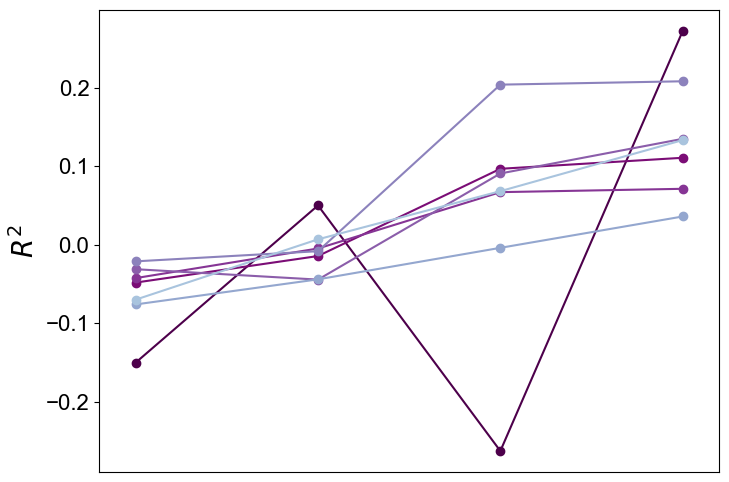

In [12]:
line_colors = generate_color_gradient(len(subjects)+3,modality)
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subjects)):
    plt.plot(scores[i,:].T,  markersize=12, marker = '.', color=line_colors[i])
    
ax.set_xticks([])
ax.set_xlim([-.2,3.2])
ax.set_ylabel('$R^2$', fontsize=20)

plt.savefig(figdir + '/r2_PCs2-N_indv_' + modality + '_4way.pdf', dpi=300, transparent=True)

plt.show()

In [13]:
scores = np.zeros([len(subjects),4,4])

for s in range(len(subjects)):
    
    tic()
    
    for pc in range(4):
    
        subj = subjects[s]
        
        vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')

        ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')

        ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
        scores[s,0,pc] = r2_score(ytest@vh.T[:,pc:pc+1], ytest_hat@vh.T[:,pc:pc+1], multioutput = 'variance_weighted')

        ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_nonlin_ytest_hat.npy')
        scores[s,1,pc] = r2_score(ytest@vh.T[:,pc:pc+1], ytest_hat@vh.T[:,pc:pc+1], multioutput = 'variance_weighted')

        ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_lin_ytest_hat.npy')
        scores[s,2,pc] = r2_score(ytest@vh.T[:,pc:pc+1], ytest_hat@vh.T[:,pc:pc+1], multioutput = 'variance_weighted')

        ytest_hat = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')
        scores[s,3,pc] = r2_score(ytest@vh.T[:,pc:pc+1], ytest_hat@vh.T[:,pc:pc+1], multioutput = 'variance_weighted')
        
    toc()

Elapsed time is 2.2762370109558105 seconds.
Elapsed time is 2.274601459503174 seconds.
Elapsed time is 2.316422462463379 seconds.
Elapsed time is 2.3094594478607178 seconds.
Elapsed time is 2.3287744522094727 seconds.
Elapsed time is 2.2974891662597656 seconds.
Elapsed time is 2.316300392150879 seconds.


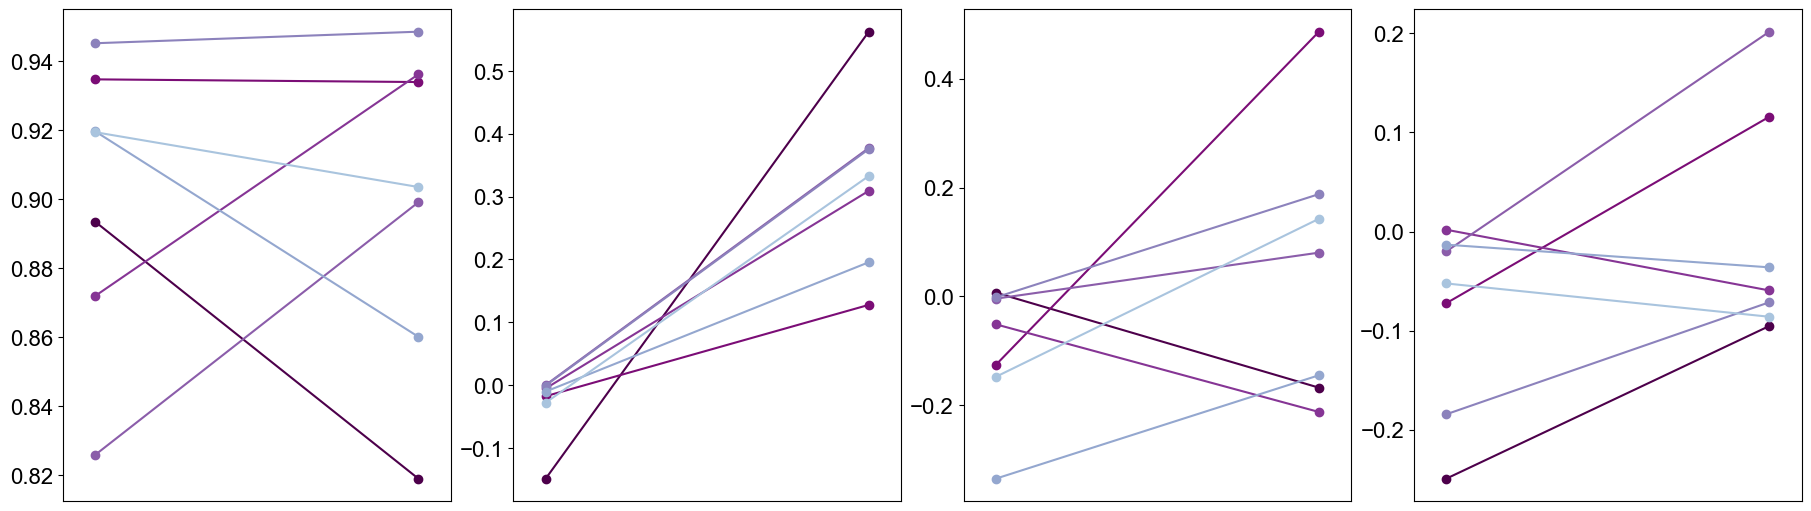

In [14]:
fig, axes = plt.subplots(1,4,sharex='col',figsize=(18,5),layout='compressed')

for pc in range(4):

    axes = axes.ravel()

    line_colors = generate_color_gradient(len(subjects)+3,modality)

    for i in range(len(subjects)):
        axes[pc].plot(scores[i,[0,-1],pc].T,  markersize=12, marker = '.', color=line_colors[i])

    axes[pc].set_xticks([])
    axes[pc].set_xlim([-.1,1.1])

plt.savefig(figdir + '/r2_PCs_indv_' + modality + '.pdf', dpi=300, transparent=True)

plt.show()

## Shuffle control

In [15]:
null_scores = np.zeros([len(subjects),len(subjects)])

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]

    print(str(s))
    
    y = load_brain(subj)

    for k in range(len(subjects)):

        print('k='+str(k))

        # Load data
        x = load_pupil(subjects[k])

        ## Train-test split
        xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=x.shape[0]-nsamples,shuffle=False)
        xtest = xtest[1000:,:] # enforce 50s (50/dt) gap to mitigate overlap between train and test
        ytest = ytest[1000:,:]

        # Fix lag at 1 s; lag ill-defined for mismatched pupil/brain recordings
        lag = 20
        xtrain = xtrain[lag:,:]
        ytrain = ytrain[:-lag,:]
        xtest = xtest[lag:,:]
        ytest = ytest[:-lag,:]

        # Time delay embedding    
        polys = legendre_polys(r, stackmax)

        Hp_train = hankel_matrix(xtrain.T,stackmax,spacing)
        Hp_test = hankel_matrix(xtest.T,stackmax,spacing)

        xtrain = Hp_train.T@polys
        xtest = Hp_test.T@polys

        xtrain = np.concatenate((xtrain,Hp_train.T[:,-1:]), axis=1)
        xtest = np.concatenate((xtest,Hp_test.T[:,-1:]), axis=1)

        ytrain = ytrain[spacing*(stackmax-1):,:]
        ytest = ytest[spacing*(stackmax-1):,:]

        # Preprocessing    
        xtrain_sc, scale_x = scaler(xtrain)
        ytrain_sc, scale_y = scaler(ytrain)

        ## Train model
        r_squared, model, encoder, decoder = VAE(xtrain_sc, ytrain_sc, latent_dim=z_n, beta=beta, num_epochs=num_epochs, anneal_step=anneal_step, verbose=False)

        # Test model
        xtest_sc,_ = scaler(xtest, scale_x)

        ytest_hat_sc = model.predict(xtest_sc)
        ytest_hat = scale_y.inverse_transform(ytest_hat_sc)
        
        null_scores[k,s] = r2_score(ytest, ytest_hat, multioutput = 'variance_weighted')

    toc()

0
k=0
k=1
k=2
k=3
k=4
k=5
k=6
Elapsed time is 150.0284550189972 seconds.
1
k=0
k=1
k=2
k=3
k=4
k=5
k=6
Elapsed time is 148.29712176322937 seconds.
2
k=0
k=1
k=2
k=3
k=4
k=5
k=6
Elapsed time is 147.71875715255737 seconds.
3
k=0
k=1
k=2
k=3
k=4
k=5
k=6
Elapsed time is 153.18580031394958 seconds.
4
k=0
k=1
k=2
k=3
k=4
k=5
k=6
Elapsed time is 150.38710379600525 seconds.
5
k=0
k=1
k=2
k=3
k=4
k=5
k=6
Elapsed time is 157.27872824668884 seconds.
6
k=0
k=1
k=2
k=3
k=4
k=5
k=6
Elapsed time is 152.98610949516296 seconds.


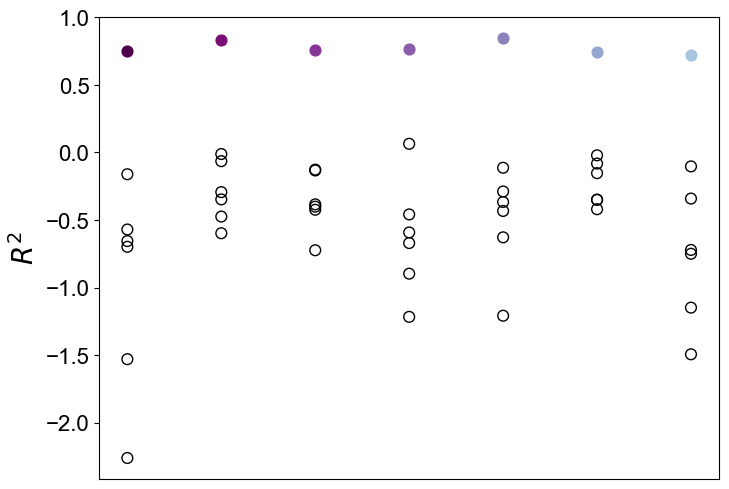

In [16]:
line_colors = generate_color_gradient(len(subjects)+3,modality)

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(subjects)):
    for j in range(len(subjects)):
        if i==j:  # Diagonal elements
            plt.scatter(i, null_scores[i,j].T, 60, color=line_colors[i], label=f'Mouse {i+1}')
        else:
            plt.scatter(i, null_scores[i,j].T, 60, facecolors='none',edgecolors='k')
                        
ax.set_xticks([])
ax.set_ylabel('$R^2$', fontsize=20)

plt.savefig(figdir + '/shuffle_indv.pdf', dpi=300, transparent=True)

plt.show()